# Neural Linear Network

相关理论部分确实太重要。而且也非常的多，所以还是分开来写比较合适。
[理论部分详见](../../notes/DiveIntoDeepLearning/Chapter3_LinearRegression.md)

In [1]:
from CommonCode import Timer
import numpy 
import tensorflow as tf
import math
import numpy as np

### 矢量化加速

f'{timer.stop():.5f} sec' [python 3.6之后字符串格式化用法参考说明](https://geek-docs.com/python/python-tutorial/python-fstring.html#Python_f)

1. 使用for循环所消耗的时间。

In [2]:
n = 10000
a = tf.ones(n)
b = tf.ones(n)

c = tf.Variable(tf.zeros(n))
timer = Timer()
for i in range(n):
    c[i].assign(a[i] + b[i])
print(c)
f'{timer.stop():.5f} sec'

<tf.Variable 'Variable:0' shape=(10000,) dtype=float32, numpy=array([2., 2., 2., ..., 2., 2., 2.], dtype=float32)>


'9.12752 sec'

2. 使用矢量化之后消耗的时间。

In [3]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00100 sec'

### normal distrubution

In [4]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

[均方误差损失函数（简称均方损失）查看笔记中关于最小二乘法的部分](../../notes/DiveIntoDeepLearning/Chapter3_LinearRegression.md)

[极大似然估计Maximum Likilihood Estimation查看笔记中关于极大似然估计的部分](../../notes/DiveIntoDeepLearning/Chapter3_LinearRegression.md)

[交叉熵cross entroy 查看笔记中关于交叉熵的部分](../../notes/DiveIntoDeepLearning/Chapter3_LinearRegression.md)

## 3.2 线性回归从零开始实现

1. 生成1000个二维数据集$\boldsymbol{X}\in \mathbb{R}^{1000 \times 2}$。
2. 模型参数$\boldsymbol{w} = [2, -3.4]^T , b=4.2$。
3. $\epsilon \backsim \mathcal{N}(0, 0.01^2)$。
4. $\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon$。

In [5]:
from matplotlib import pyplot as plt
import tensorflow as tf
import random

In [6]:
def synthetic_data(w, b, num_examples): 
    """生成y=Xw+b+噪声"""
    # num_examples数据数量，w.shape[0]表示另外一个维度。
    # 初始化为全零矩阵。
    X = tf.zeros((num_examples, w.shape[0]))
    # 按照正态分布生成数据。
    X += tf.random.normal(shape=X.shape)
    # 生成y。
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    # print(y)
    # 加上一个噪声。
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    # 将形状修改为列的形式。
    y = tf.reshape(y, (-1, 1))
    return X, y

true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
# print(features, labels)

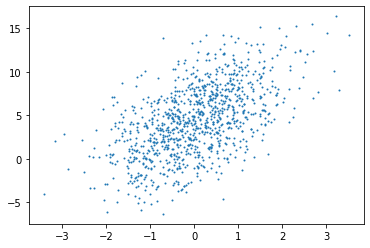

In [7]:
plt.scatter(features[:, (0)].numpy(), labels.numpy(), 1)
plt.show()

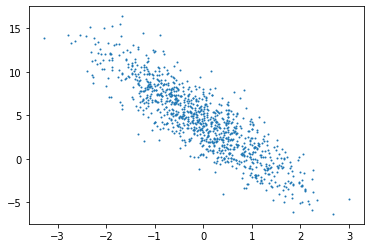

In [8]:
plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1)
plt.show()

使用GPU：中数据也是分成小批量的分别放到不同的GPU中。

[yield的说明参见](../BasicKnowledgePoints/2Python.md)

[yield的代码参见](../../codes/4BasicKnowledgePoints/4BasicPython.ipynb)中关于return和yield的代码。

[tf.gather()的说明详见tensorflow中的代码](../../codes/8TensorFlowGuide/1TensorFlowFoundation.ipynb)。作用就是获取指定维度上的所有元素。以二维矩阵为例，输入多个行的index，就提取指定行的所有元素；所欲多个列的index，就提取指定列的所有元素。

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # 获取所有数据的index。
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序。
    # random.shuffle()将indices列表中元素的顺序打乱了。
    random.shuffle(indices)
    # range(0, num_examples, batch_size)以0为下限，以num_examples为上限（不含num_examples），以batch_size为步长。
    for i in range(0, num_examples, batch_size):
        # 每次取一个batch_size的样本。
        # 样本数不能被批次数整除的时候提取出来的最后一个j的样本数比其他的小批量的样本数少。
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        # 使用next()来一次一次的取出一个小批量的样本。
        yield tf.gather(features, j), tf.gather(labels, j)

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    # 取一次的验证一下打印出来。
    break

tf.Tensor(
[[-0.9825917  -1.1402723 ]
 [-1.0650537   0.41340002]
 [-0.4979561   2.3372507 ]
 [ 0.6512047  -2.5444102 ]
 [ 0.54530925  2.2409317 ]
 [ 1.8732243   0.18682724]
 [-0.14927736  0.9502797 ]
 [-1.0189743   0.6370071 ]
 [-0.25408164 -0.30827254]
 [-0.7162933   0.14573352]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[ 6.1117287e+00]
 [ 6.6635495e-01]
 [-4.7442036e+00]
 [ 1.4166477e+01]
 [-2.3303230e+00]
 [ 7.2869062e+00]
 [ 6.7388570e-01]
 [-8.2789054e-03]
 [ 4.7390018e+00]
 [ 2.2730119e+00]], shape=(10, 1), dtype=float32)


书中说明：当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。**上面实现的迭代**对于教学来说很好，但它的**执行效率很低**，可能会在实际问题上陷入麻烦。例如，**它要求我们将所有数据加载到内存中，并执行大量的随机内存访问**。在深度学习框架中实现的内置迭代器效率要高得多，它可以处理存储在文件中的数据和数据流提供的数据。

初始化模型参数。

两种定义权重$\boldsymbol{w}$的方式。后面3.2.9有练习需要回答。从结果来看两者并没有什么不同。

1. 将权重初始化为$\boldsymbol{w} \backsim \mathcal{N}(0, 0.01^2)$；
2. 将权重初始化为0。

In [11]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01), trainable=True)
# w = tf.Variable(tf.zeros([2, 1], dtype=float), trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

定义模型

In [12]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return tf.matmul(X, w) + b

定义损失函数

In [13]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

定义优化算法

1. [zip的使用详见](../../codes/4BasicKnowledgePoints/4BasicPython.ipynb)中关于zip的说明。
2. [param.assign_sub的使用详见中关于assign_sub函数的说明](../../codes/8TensorFlowGuide/1TensorFlowFoundation.ipynb)。param_1.assign_sub(param_2)的作用是将矩阵param_1**减去**矩阵param_2。实际上就是完成的Tensor之间的减法。

In [14]:
def sgd(params, grads, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    # print(type(params))
    # params是list类型。
    for param, grad in zip(params, grads):
        # print(type(param))
        # param是<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>类型。
        param.assign_sub(lr*grad/batch_size)

训练

执行的步骤如下：
1. 初始化参数
2. 重复以下训练，直到完成：
   1. 计算梯度$\boldsymbol{g} \leftarrow \partial_(\boldsymbol{w}, \boldsymbol{b})\frac{1}{|B|}\sum\limits_{i\in B}l(x_i, y_i, \boldsymbol{w}, \boldsymbol{b})$;
   2. 更新参数$(\boldsymbol{w},\boldsymbol{b})\leftarrow (\boldsymbol{w},\boldsymbol{b})-\eta \boldsymbol{g}$。

In [15]:
lr = 0.03
num_epochs = 3
# 传指针了。
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 计算l关于[w,b]的梯度
        dw, db = g.gradient(l, [w, b])
        # 使用参数的梯度更新参数
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 0.024227
epoch 2, loss 0.000085
epoch 3, loss 0.000050


测试不同学习率对损失函数收敛的影响

In [18]:
num_epochs = 5
# 传指针了。
net = linreg
loss = squared_loss

lrs = [0.1, 0.05, 0.03, 0.01, 0.005]

for lr_one in lrs:
    print("different learning rate {}".format(lr_one))
    # w, b重新初始化一次。
    w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01), trainable=True)
    # w = tf.Variable(tf.zeros([2, 1], dtype=float), trainable=True)
    b = tf.Variable(tf.zeros(1), trainable=True)
    for epoch in range(num_epochs):
        for X, y in data_iter(batch_size, features, labels):
            with tf.GradientTape() as g:
                l = loss(net(X, w, b), y)  # X和y的小批量损失
            # 计算l关于[w,b]的梯度
            dw, db = g.gradient(l, [w, b])
            # 使用参数的梯度更新参数
            sgd([w, b], [dw, db], lr_one, batch_size)
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')
    print("\n")

different learning rate 0.1
epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051
epoch 4, loss 0.000051
epoch 5, loss 0.000051


different learning rate 0.05
epoch 1, loss 0.000346
epoch 2, loss 0.000050
epoch 3, loss 0.000051
epoch 4, loss 0.000051
epoch 5, loss 0.000051


different learning rate 0.03
epoch 1, loss 0.024384
epoch 2, loss 0.000089
epoch 3, loss 0.000051
epoch 4, loss 0.000050
epoch 5, loss 0.000051


different learning rate 0.01
epoch 1, loss 2.024262
epoch 2, loss 0.229989
epoch 3, loss 0.026513
epoch 4, loss 0.003141
epoch 5, loss 0.000414


different learning rate 0.005
epoch 1, loss 6.062226
epoch 2, loss 2.043034
epoch 3, loss 0.690374
epoch 4, loss 0.234018
epoch 5, loss 0.079589




In [16]:
print(f'w的估计误差: {true_w - tf.reshape(w, true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: [0.00020146 0.00041842]
b的估计误差: [0.000319]


## 3.2.9 回答其中的问题

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
   1. 将权重初始化为0时的误差：
      w的估计误差: [-5.29289246e-05 -1.16586685e-04]
      b的估计误差: [0.00093889]

   2. 将权重初始化$\boldsymbol{w} \backsim \mathcal{N}(0, 0.01^2)$是的误差：
      w的估计误差: [-0.00013304  0.00035238]
      b的估计误差: [0.00056028]
   
   答：通过实验可以看到算法依然有效。并没有发生想象中误差增大的情况，反而$\boldsymbol{w}$的误差变小了。
2. 假设你是乔治·西蒙·欧姆，试图为电压和电流的关系建立一个模型。你能使用自动微分来学习模型的参数吗?\
   答：给数据就可以完成。
3. 您能基于普朗克定律使用光谱能量密度来确定物体的温度吗？
4. 如果你想计算二阶导数可能会遇到什么问题？你会如何解决这些问题？
5. 为什么在squared_loss函数中需要使用reshape函数？
   答：设向量x，那么x的大小可以表示为$\boldsymbol{x}^T \boldsymbol{x}$。两个向量$\boldsymbol{x}$和$\boldsymbol{y}$之间的距离可以表示为$\boldsymbol{x}^T \boldsymbol{y}$。也就是两个向量之间的L2范数。
6. 尝试使用不同的学习率，观察损失函数值下降的快慢。\
   答：太大的学习率会导致损失函数值完全无法下降；太小的学习率会导致损失函数下降得太慢，这就需要更多的轮次来训练。
7. 如果样本个数不能被批量大小整除，data_iter函数的行为会有什么变化？\
   答：最后一个批次的数据变少。

## 3.3 线性回归的简洁实现

以下代码全部来自于李沐老师的《机器学习》中。需要试验一次看效果，并且添加注释。

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
true_w = tf.constant([2, -3.4])
true_b = 4.2

def synthetic_data(w, b, num_examples): 
    """生成y=Xw+b+噪声"""
    # num_examples数据数量，w.shape[0]表示另外一个维度。
    # 初始化为全零矩阵。
    X = tf.zeros((num_examples, w.shape[0]))
    # 按照正态分布生成数据。
    X += tf.random.normal(shape=X.shape)
    # 生成y。
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    # print(y)
    # 加上一个噪声。
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    # 将形状修改为列的形式。
    y = tf.reshape(y, (-1, 1))
    return X, y

features, labels = synthetic_data(true_w, true_b, 1000)

1. tf.data.Dataset.from_tensor_slices和其中使用的参考<https://zhuanlan.zhihu.com/p/380141130>
2. 相关函数的试验在[from_tensor_slices函数的试验效果](../../codes/8TensorFlowGuide/1TensorFlowFoundation.ipynb)详见1TensorFlowFoundation.ipynb中进行。


In [ ]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个TensorFlow数据迭代器"""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

batch_size = 10
data_iter = load_array((features, labels), batch_size)